In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [2]:
# Optional: nicer tables
pd.set_option('display.max_columns', 100)

# --------------- Load ---------------
FILE = '/content/drive/MyDrive/RawData_PaylaterandNonPaylaterUser.csv'
df = pd.read_csv(FILE, delimiter=';')

# strip whitespace from column names (your file has a few trailing spaces)
df.columns = [c.strip() for c in df.columns]

# quick peek
print(df.shape)
print(df.dtypes)
df.head()

(810, 35)
Gender                                                                           int64
E-Paylater User Status                                                           int64
Educational Background                                                           int64
Year of Birth                                                                    int64
Job Status                                                                       int64
Monthly Income                                                                   int64
Average monthly expenditure for online shopping in relation to monthly income    int64
IBB1                                                                             int64
IBB2                                                                             int64
IBB3                                                                             int64
IBB4                                                                             int64
P1                               

,Gender,E-Paylater User Status,Educational Background,Year of Birth,Job Status,Monthly Income,Average monthly expenditure for online shopping in relation to monthly income,IBB1,IBB2,IBB3,IBB4,P1,P2,P3,P4,SI1,SI2,SI3,SI4,SI5,SI6,H1,H2,H3,H4,SC1,SC2,SC3,SC4,SC5,NE1,NE2,NE3,NE4,NE5
0,2,1,3,1997,2,3,1,3,3,3,1,3,3,3,3,2,2,2,2,1,1,4,3,4,3,5,5,3,3,4,3,3,4,3,2
1,1,2,1,2002,1,2,2,3,1,2,1,3,4,3,3,1,1,1,4,2,3,4,4,4,4,4,4,2,3,4,5,5,5,5,4
2,1,1,1,2002,1,2,1,3,3,3,3,3,3,3,3,3,4,3,3,3,3,4,4,4,4,4,4,2,2,2,3,3,3,3,3
3,2,2,3,2002,1,1,1,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,2,4,2,2,2,1,1,1,2,1
4,1,2,3,2002,2,6,1,1,1,1,1,2,2,2,2,2,1,2,3,1,2,3,3,4,3,5,2,3,1,5,3,3,2,3,3


In [3]:
df.head()

,Gender,E-Paylater User Status,Educational Background,Year of Birth,Job Status,Monthly Income,Average monthly expenditure for online shopping in relation to monthly income,IBB1,IBB2,IBB3,IBB4,P1,P2,P3,P4,SI1,SI2,SI3,SI4,SI5,SI6,H1,H2,H3,H4,SC1,SC2,SC3,SC4,SC5,NE1,NE2,NE3,NE4,NE5
0,2,1,3,1997,2,3,1,3,3,3,1,3,3,3,3,2,2,2,2,1,1,4,3,4,3,5,5,3,3,4,3,3,4,3,2
1,1,2,1,2002,1,2,2,3,1,2,1,3,4,3,3,1,1,1,4,2,3,4,4,4,4,4,4,2,3,4,5,5,5,5,4
2,1,1,1,2002,1,2,1,3,3,3,3,3,3,3,3,3,4,3,3,3,3,4,4,4,4,4,4,2,2,2,3,3,3,3,3
3,2,2,3,2002,1,1,1,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,2,4,2,2,2,1,1,1,2,1
4,1,2,3,2002,2,6,1,1,1,1,1,2,2,2,2,2,1,2,3,1,2,3,3,4,3,5,2,3,1,5,3,3,2,3,3


In [4]:
# Standardize target and key fields
TARGET = 'E-Paylater User Status'

# Convert to numeric if not already (robust)
df[TARGET] = pd.to_numeric(df[TARGET], errors='coerce')

# Fix known spacey cols if present
for c in ['SC3 ', 'SC4 ']:
    if c in df.columns:
        df[c.strip()] = df[c]
        df.drop(columns=[c], inplace=True)

# Year of Birth -> Age (if present)
if 'Year of Birth' in df.columns:
    df['Age'] = pd.to_numeric(df['Year of Birth'], errors='coerce')
    df['Age'] = pd.to_datetime('today').year - df['Age']

# Ensure numeric for Likert/survey items
likert_prefixes = ['IBB', 'P', 'SI', 'H', 'SC', 'NE']
likert_cols = [c for c in df.columns if any(c.startswith(p) for p in likert_prefixes)]
for c in likert_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Basic missing inspection
missing = df.isna().sum().sort_values(ascending=False)
print("Missing (top 10):")
print(missing.head(10))

# Drop rows with missing target
df = df.dropna(subset=[TARGET]).copy()


Missing (top 10):
Gender                                                                           0
E-Paylater User Status                                                           0
Educational Background                                                           0
Year of Birth                                                                    0
Job Status                                                                       0
Monthly Income                                                                   0
Average monthly expenditure for online shopping in relation to monthly income    0
IBB1                                                                             0
IBB2                                                                             0
IBB3                                                                             0
dtype: int64


In [5]:
# Overall numeric summary
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
desc = df[num_cols].describe().T
desc[['mean','std','min','25%','50%','75%','max']].round(3)


,mean,std,min,25%,50%,75%,max
Gender,1.680,0.467,1.0,1.0,2.0,2.0,2.0
E-Paylater User Status,1.252,0.434,1.0,1.0,1.0,2.0,2.0
Educational Background,2.285,1.162,1.0,1.0,3.0,3.0,4.0
Year of Birth,1994.111,10.021,1966.0,1987.0,1999.0,2002.0,2005.0
Job Status,1.641,0.777,1.0,1.0,2.0,2.0,4.0
Monthly Income,2.809,1.850,1.0,1.0,2.0,4.0,6.0
Average monthly expenditure for online shopping in relation to monthly income,1.506,0.801,1.0,1.0,1.0,2.0,6.0
IBB1,3.053,1.117,1.0,2.0,3.0,4.0,5.0
IBB2,2.749,1.166,1.0,2.0,3.0,4.0,5.0
IBB3,2.804,1.098,1.0,2.0,3.0,4.0,5.0


In [6]:
# Target distribution
print("Target distribution:")
print(df[TARGET].value_counts(dropna=False))


Target distribution:
E-Paylater User Status
1    606
2    204
Name: count, dtype: int64


In [7]:
# Demographic cross-tabs (if present)
for col in ['Gender', 'Educational Background', 'Job Status', 'Monthly Income']:
    if col in df.columns:
        print(f"\n{col} by {TARGET}:")
        print(pd.crosstab(df[col], df[TARGET], normalize='index').round(3))



Gender by E-Paylater User Status:
E-Paylater User Status      1      2
Gender                              
1                       0.730  0.270
2                       0.757  0.243

Educational Background by E-Paylater User Status:
E-Paylater User Status      1      2
Educational Background              
1                       0.802  0.198
2                       0.690  0.310
3                       0.665  0.335
4                       0.814  0.186

Job Status by E-Paylater User Status:
E-Paylater User Status      1      2
Job Status                          
1                       0.808  0.192
2                       0.697  0.303
3                       0.742  0.258
4                       0.575  0.425

Monthly Income by E-Paylater User Status:
E-Paylater User Status      1      2
Monthly Income                      
1                       0.818  0.182
2                       0.769  0.231
3                       0.755  0.245
4                       0.557  0.443
5                 

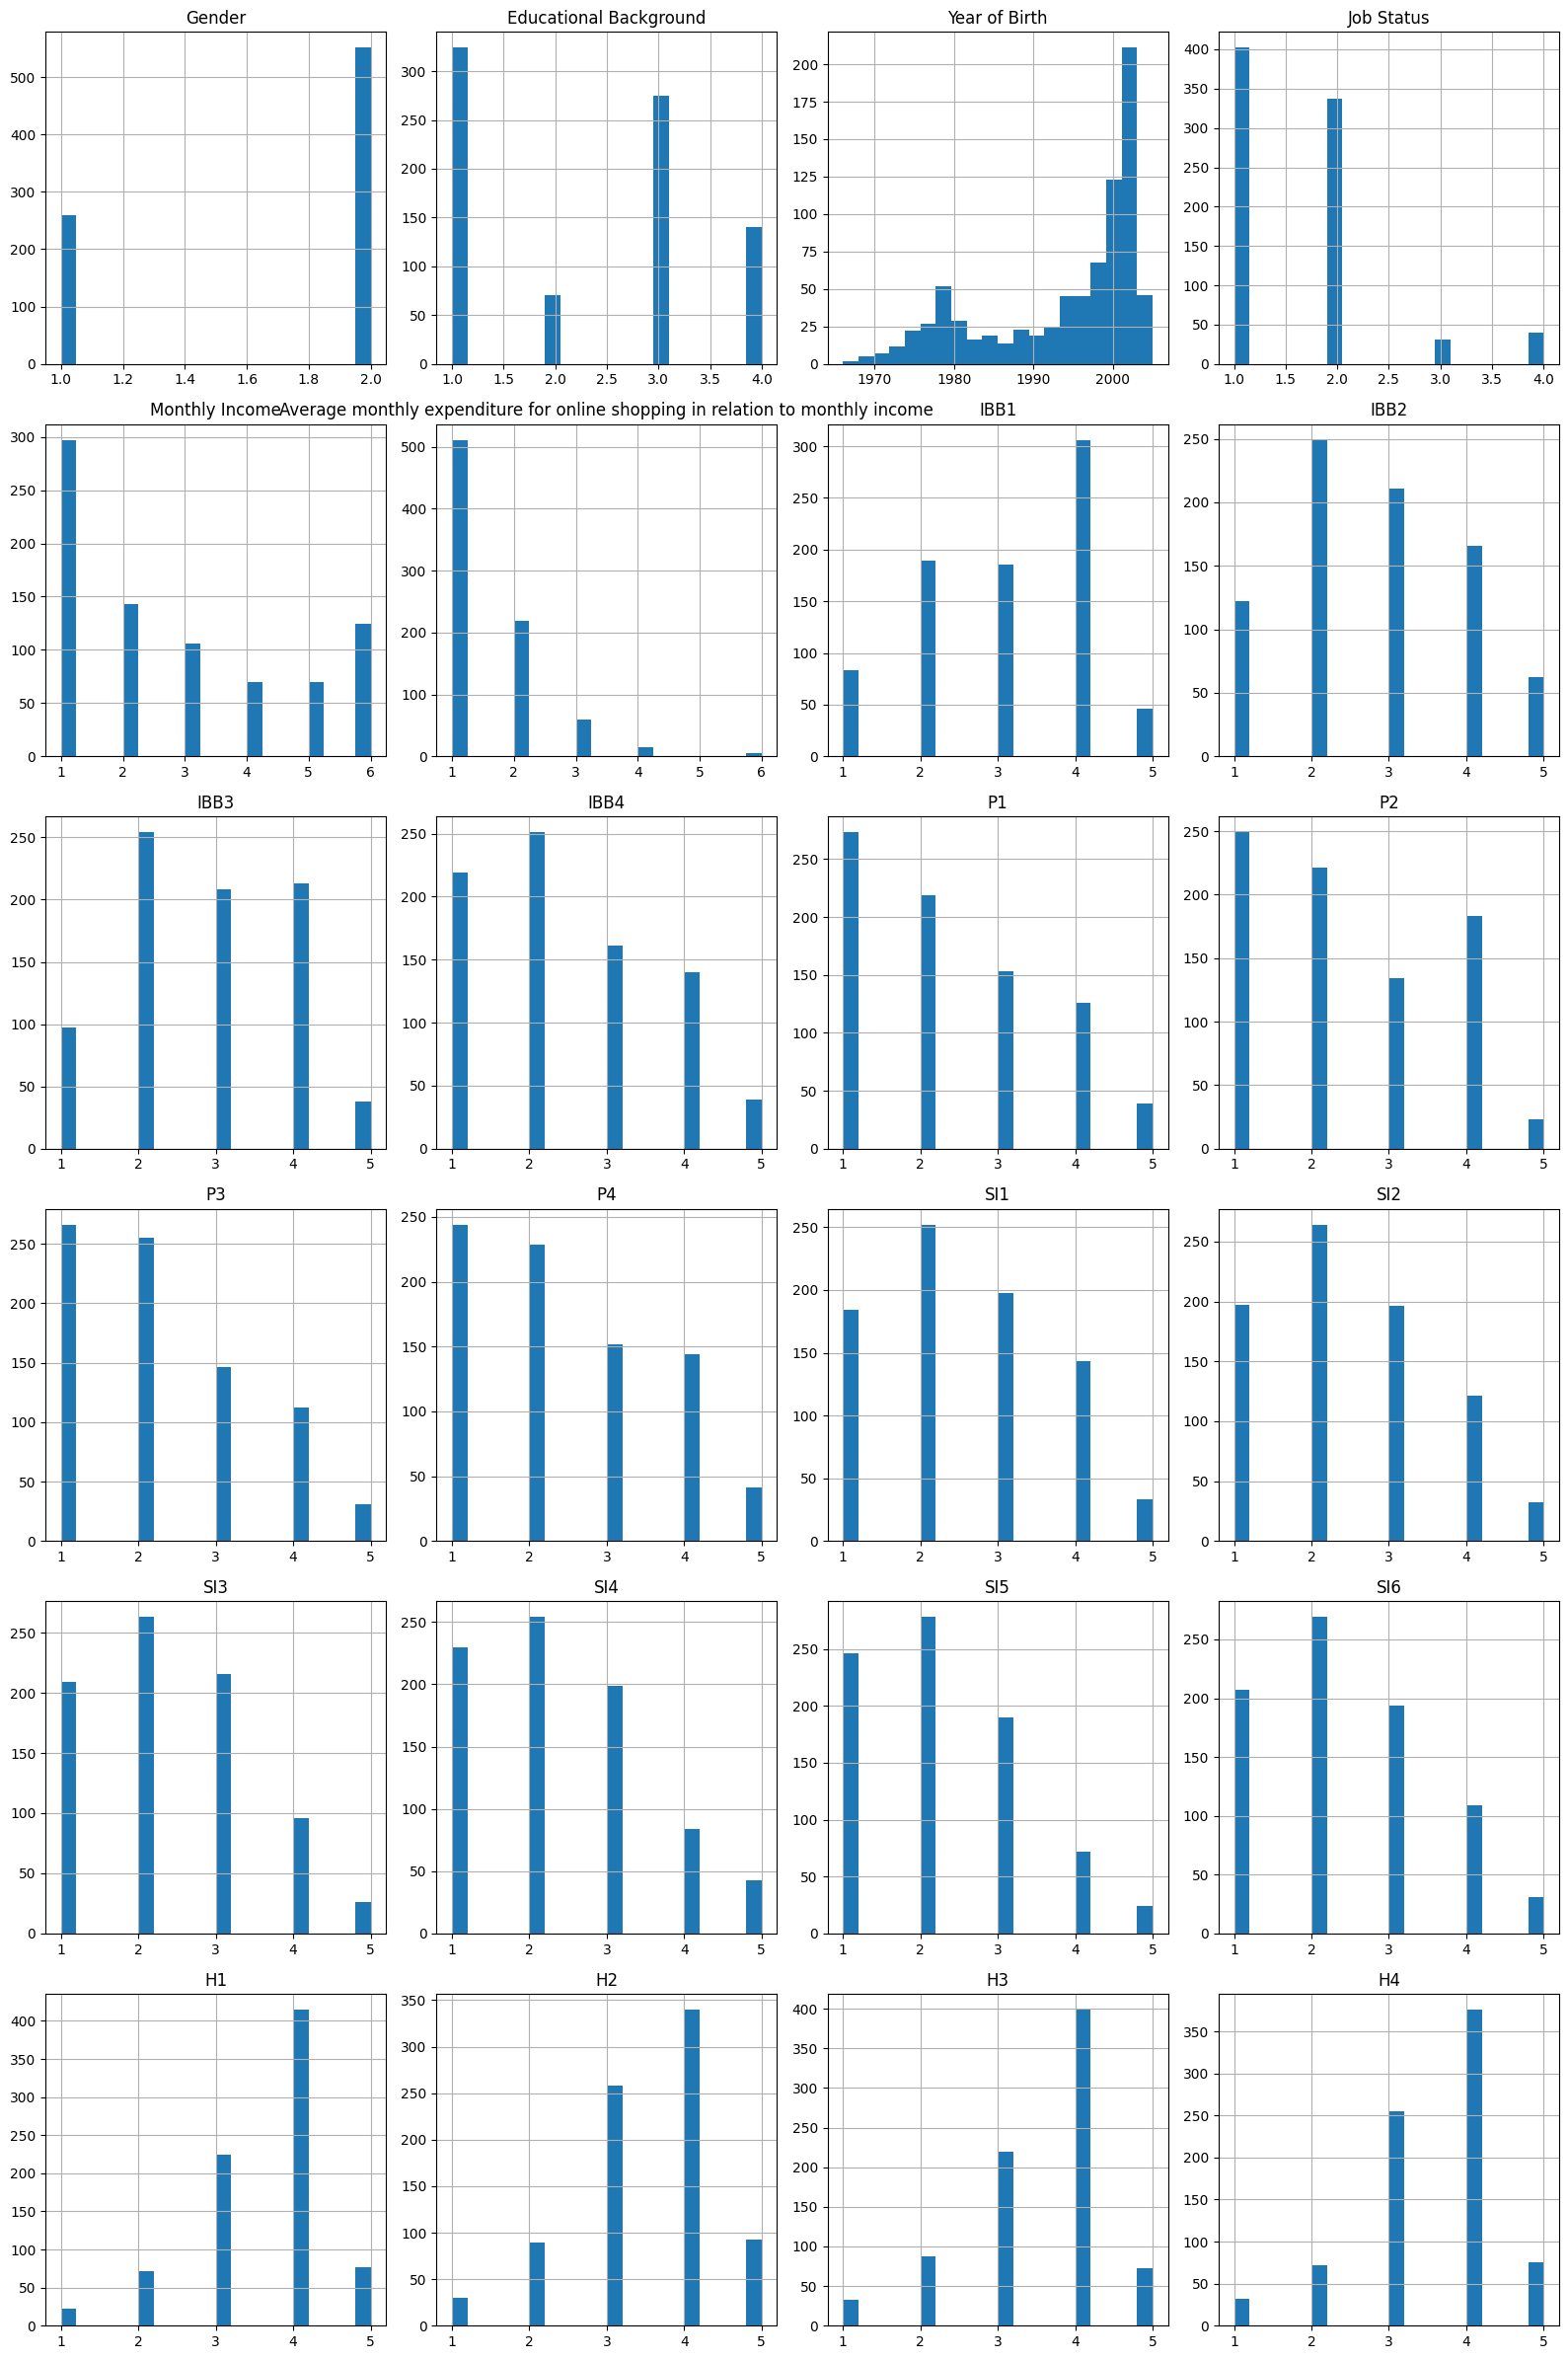

In [8]:
# Histograms for numeric variables (small multiples)
cols_to_plot = [c for c in num_cols if c != TARGET][:24]  # limit to first 24 to avoid huge grids
n = len(cols_to_plot)
rows = int(np.ceil(n/4))
plt.figure(figsize=(16, 4*rows))
for i, c in enumerate(cols_to_plot, 1):
    plt.subplot(rows, 4, i)
    df[c].hist(bins=20)
    plt.title(c)
    plt.tight_layout()
plt.show()


<Figure size 500x300 with 0 Axes>

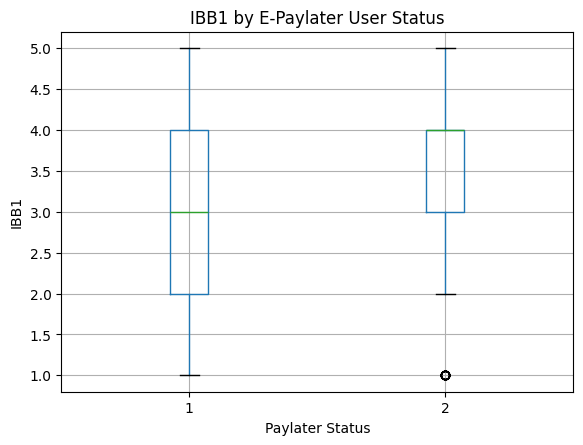

<Figure size 500x300 with 0 Axes>

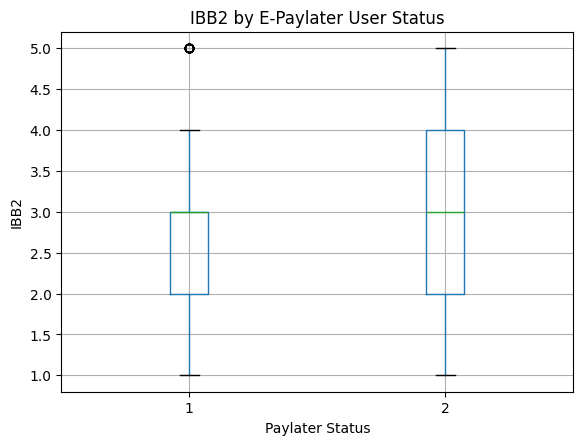

<Figure size 500x300 with 0 Axes>

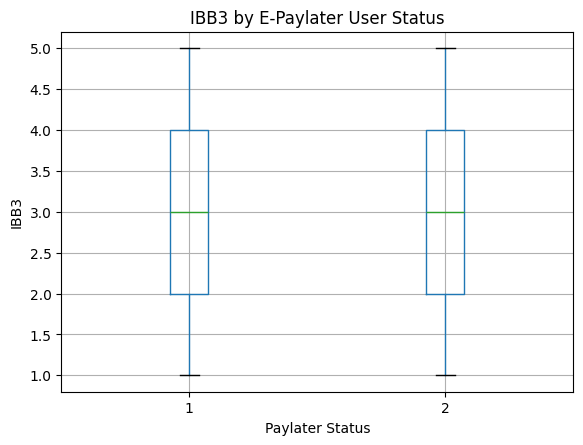

<Figure size 500x300 with 0 Axes>

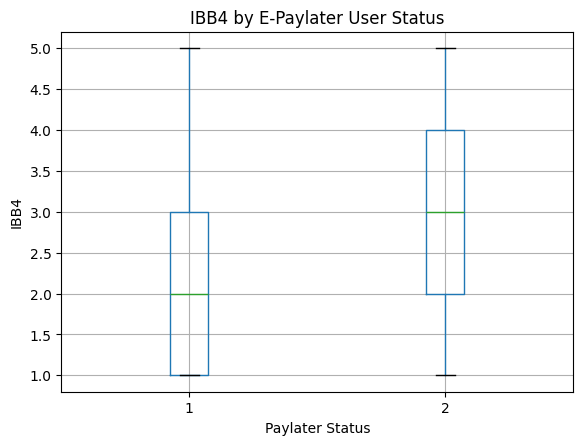

<Figure size 500x300 with 0 Axes>

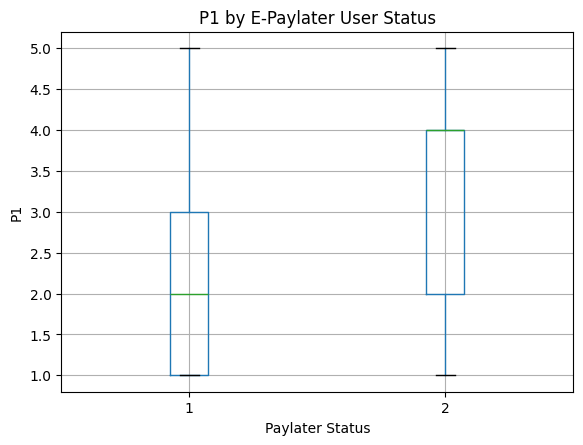

<Figure size 500x300 with 0 Axes>

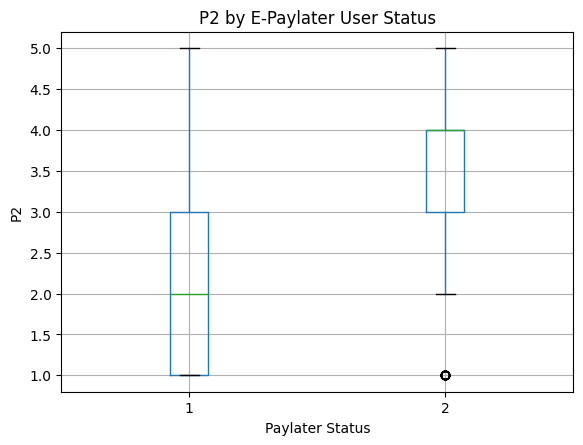

<Figure size 500x300 with 0 Axes>

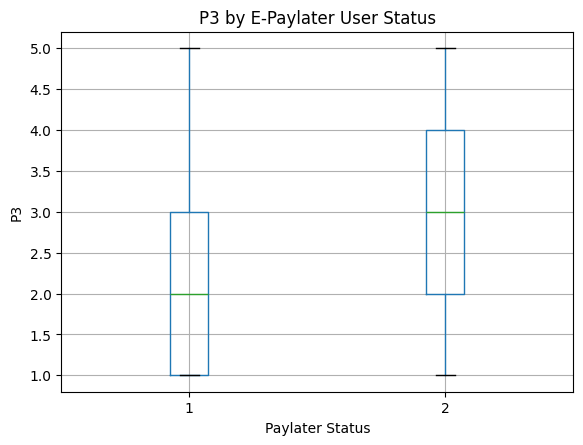

<Figure size 500x300 with 0 Axes>

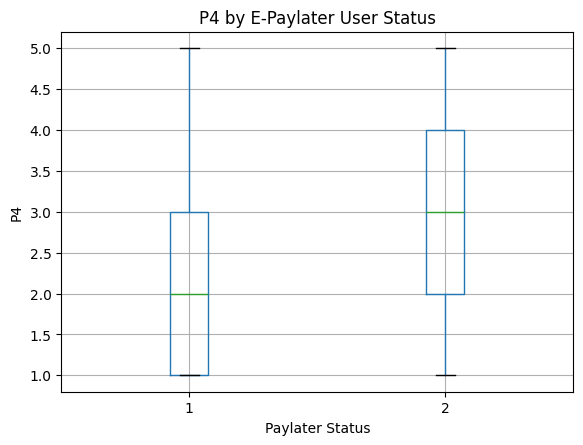

<Figure size 500x300 with 0 Axes>

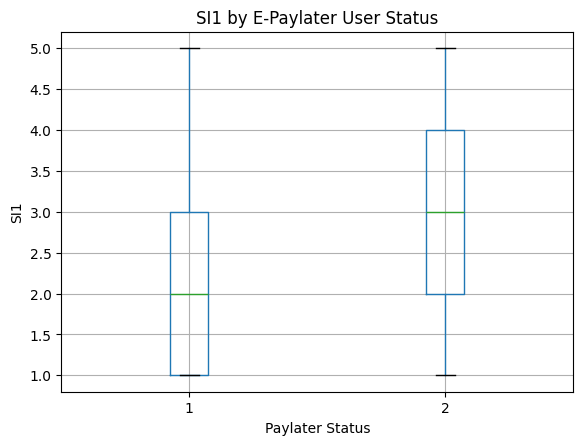

<Figure size 500x300 with 0 Axes>

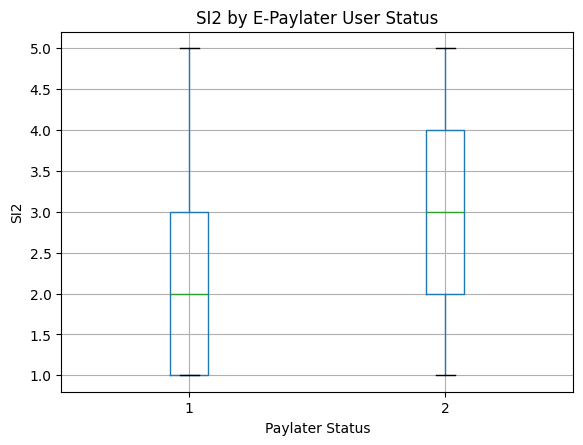

<Figure size 500x300 with 0 Axes>

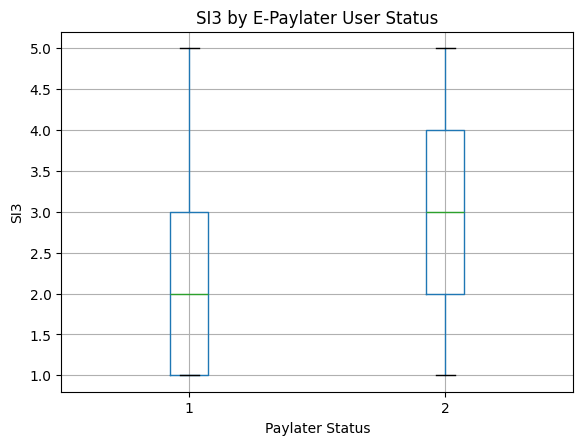

<Figure size 500x300 with 0 Axes>

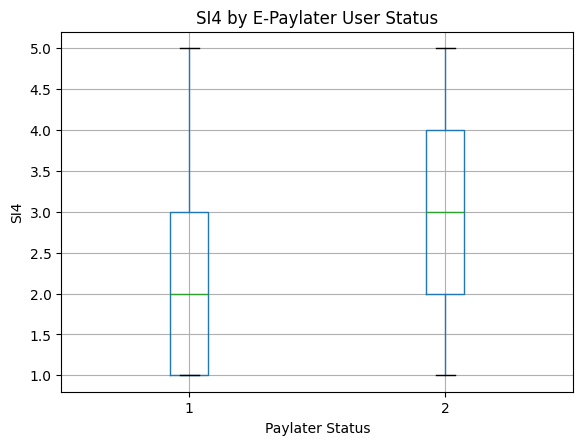

In [9]:
# Boxplots by target for Likert items
subset = likert_cols[:12]  # plot a subset to keep things readable
for c in subset:
    if c in df.columns:
        plt.figure(figsize=(5,3))
        df.boxplot(column=c, by=TARGET)
        plt.title(f'{c} by {TARGET}')
        plt.suptitle('')
        plt.xlabel('Paylater Status')
        plt.ylabel(c)
        plt.show()


In [10]:
# Pearson correlations among numeric variables
corr = df[num_cols].corr()
corr[TARGET].sort_values(ascending=False).head(20)


,E-Paylater User Status
E-Paylater User Status,1.000000
P1,0.476475
P2,0.464472
SI1,0.402605
SI3,0.389656
P4,0.389282
P3,0.361173
SI6,0.349437
SI2,0.331560
SI4,0.322520


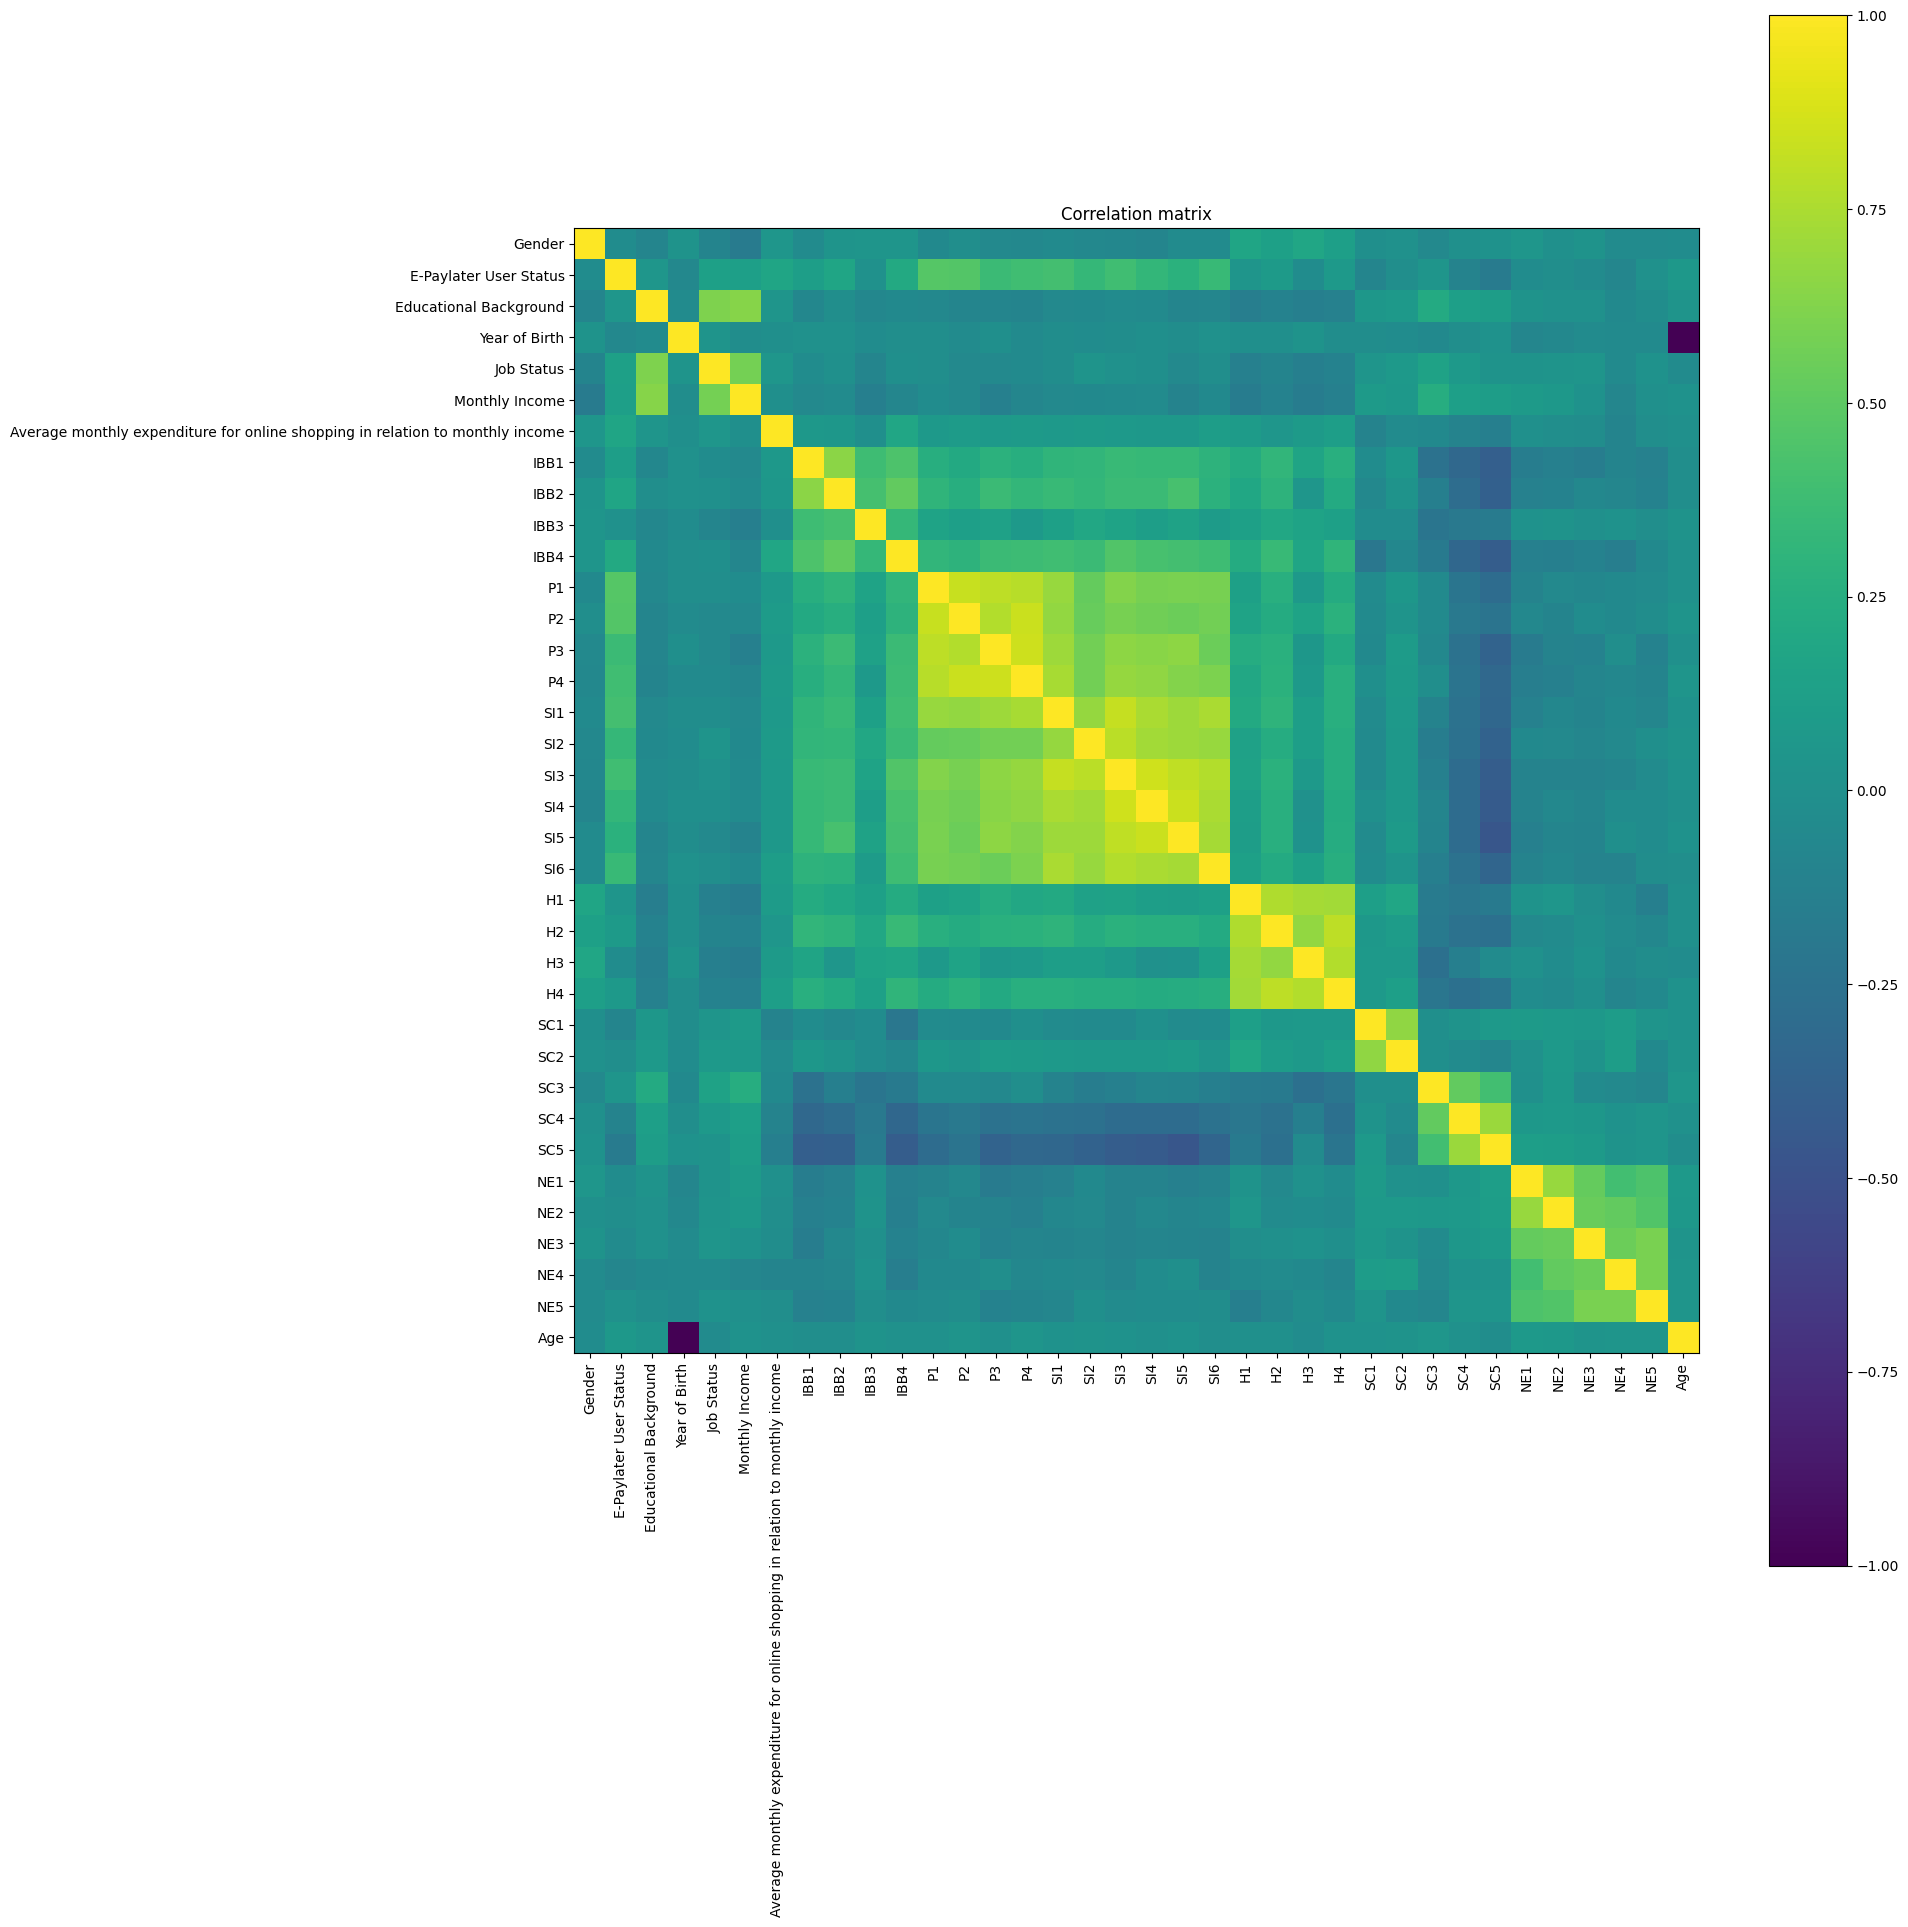

In [11]:
# Simple heatmap (matplotlib only)
plt.figure(figsize=(20,20))
plt.imshow(corr, interpolation='nearest')
plt.title('Correlation matrix')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.colorbar()
plt.tight_layout()
plt.show()


In [12]:
# --- Step 6) Group Comparisons: Users vs Non-users (ROBUST) ---
from scipy import stats
import numpy as np
import pandas as pd

def compare_groups(
    df,
    target='E-Paylater User Status',
    cols=None,
    min_per_group=5,
    use_nonparametric_if_violations=True,
    verbose=True
):
    """
    Compares target==1 vs target==0 for the specified columns.
    Returns a safely-shaped DataFrame (never crashes if nothing is testable).
    """
    # default: all numeric except target
    if cols is None:
        cols = df.select_dtypes(include=[np.number]).columns.drop([target], errors='ignore').tolist()

    # define groups
    g1 = df[df[target] == 1]
    g0 = df[df[target] == 0]

    results, skipped = [], []

    for c in cols:
        if c == target:
            continue

        # numeric coercion
        x1 = pd.to_numeric(g1[c], errors='coerce').dropna()
        x0 = pd.to_numeric(g0[c], errors='coerce').dropna()

        # sample size check
        if len(x1) < min_per_group or len(x0) < min_per_group:
            skipped.append((c, f"insufficient samples (users={len(x1)}, nonusers={len(x0)})"))
            continue

        # constant checks
        if np.nanstd(x1) == 0 and np.nanstd(x0) == 0:
            skipped.append((c, "both groups are constant"))
            continue

        # normality (guarded)
        try:
            p_norm1 = stats.shapiro(x1.sample(min(500, len(x1)), random_state=0))[1] if len(x1) >= 3 else 0.0
            p_norm0 = stats.shapiro(x0.sample(min(500, len(x0)), random_state=0))[1] if len(x0) >= 3 else 0.0
        except Exception:
            p_norm1 = p_norm0 = 0.0  # force nonparametric

        # variance equality (guarded)
        try:
            p_levene = stats.levene(x1, x0, center='median')[1]
        except Exception:
            p_levene = 0.0

        # choose and run test
        try:
            if use_nonparametric_if_violations and (p_norm1 < 0.05 or p_norm0 < 0.05):
                test_name = 'Mann-Whitney U'
                stat, p = stats.mannwhitneyu(x1, x0, alternative='two-sided')
            else:
                equal_var = p_levene >= 0.05
                test_name = "Student t-test" if equal_var else "Welch t-test"
                stat, p = stats.ttest_ind(x1, x0, equal_var=equal_var)
        except Exception as e:
            skipped.append((c, f"test failed: {e}"))
            continue

        # effect size (Cohen's d; pooled SD)
        try:
            sx1, sx0 = np.var(x1, ddof=1), np.var(x0, ddof=1)
            pooled_sd = np.sqrt((sx1 + sx0) / 2.0)
            d = (np.mean(x1) - np.mean(x0)) / pooled_sd if pooled_sd > 0 else np.nan
        except Exception:
            d = np.nan

        results.append({
            'variable': c,
            'mean_users': float(np.mean(x1)),
            'mean_nonusers': float(np.mean(x0)),
            'delta': float(np.mean(x1) - np.mean(x0)),
            'effect_size_d': float(d),
            'test': test_name,
            'statistic': float(stat),
            'p_value': float(p)
        })

    # assemble output with stable columns
    cols_out = ['variable', 'mean_users', 'mean_nonusers', 'delta', 'effect_size_d', 'test', 'statistic', 'p_value']
    out_df = pd.DataFrame(results, columns=cols_out)

    # sort if possible
    if not out_df.empty and 'p_value' in out_df.columns:
        out_df = out_df.sort_values('p_value', ascending=True).reset_index(drop=True)

    if verbose and skipped:
        print("Skipped variables (reason):")
        for name, why in skipped[:25]:
            print(f" - {name}: {why}")
        if len(skipped) > 25:
            print(f" ... and {len(skipped)-25} more")

    return out_df

# ----- Run it on your Likert items -----
# Ensure trimmed column names (safe to run even if done earlier)
df.columns = [c.strip() for c in df.columns]

likert_prefixes = ['IBB', 'P', 'SI', 'H', 'SC', 'NE']
likert_cols = [c for c in df.columns if any(c.startswith(p) for p in likert_prefixes)]

group_diff = compare_groups(
    df,
    target='E-Paylater User Status',
    cols=likert_cols,
    min_per_group=5,
    use_nonparametric_if_violations=True,
    verbose=True
)

# Peek at the top effects
group_diff.head(20)


Skipped variables (reason):
 - IBB1: insufficient samples (users=606, nonusers=0)
 - IBB2: insufficient samples (users=606, nonusers=0)
 - IBB3: insufficient samples (users=606, nonusers=0)
 - IBB4: insufficient samples (users=606, nonusers=0)
 - P1: insufficient samples (users=606, nonusers=0)
 - P2: insufficient samples (users=606, nonusers=0)
 - P3: insufficient samples (users=606, nonusers=0)
 - P4: insufficient samples (users=606, nonusers=0)
 - SI1: insufficient samples (users=606, nonusers=0)
 - SI2: insufficient samples (users=606, nonusers=0)
 - SI3: insufficient samples (users=606, nonusers=0)
 - SI4: insufficient samples (users=606, nonusers=0)
 - SI5: insufficient samples (users=606, nonusers=0)
 - SI6: insufficient samples (users=606, nonusers=0)
 - H1: insufficient samples (users=606, nonusers=0)
 - H2: insufficient samples (users=606, nonusers=0)
 - H3: insufficient samples (users=606, nonusers=0)
 - H4: insufficient samples (users=606, nonusers=0)
 - SC1: insufficient s

,variable,mean_users,mean_nonusers,delta,effect_size_d,test,statistic,p_value


Explained variance ratio:
PC1    0.799
PC2    0.055
PC3    0.054
PC4    0.045
PC5    0.027
PC6    0.019
dtype: float64


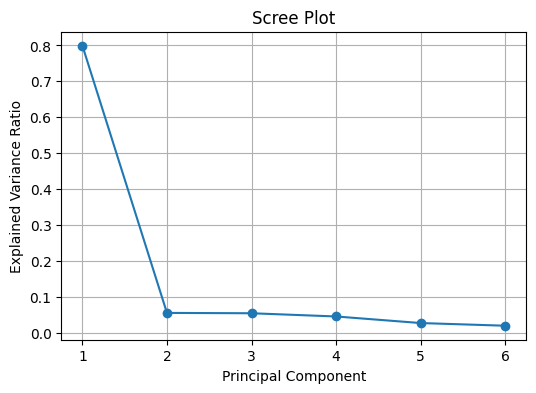

,PC1,PC2,PC3,PC4,PC5,PC6,E-Paylater User Status
0,-1.524848,0.345028,-0.141524,-0.739127,-0.527560,-0.032911,1
1,-0.789509,-1.657249,-0.291715,1.130044,-1.227345,-1.038553,2
2,1.771062,0.558019,-0.526955,0.148822,0.163514,-0.122589,1
3,3.629317,-0.110368,-0.144996,0.109407,0.152431,0.057144,2
4,-1.148780,-0.689179,0.442000,-0.216315,-1.230763,-0.224635,2


In [13]:
# Pick one block (e.g., Social Influence SI1..SI6) if present
si_cols = [c for c in df.columns if c.startswith('SI')]
block = si_cols if len(si_cols) >= 3 else likert_cols  # fallback to all likert if SI missing

# Drop rows with missing in the block
X = df[block].dropna().copy()

# Standardize (PCA expects mean-centered)
scaler = StandardScaler()
Xz = scaler.fit_transform(X)

pca = PCA(n_components=min(6, X.shape[1]))
Z = pca.fit_transform(Xz)

# Variance explained
explained = pd.Series(pca.explained_variance_ratio_,
                      index=[f'PC{i+1}' for i in range(pca.n_components_)])
print("Explained variance ratio:")
print(explained.round(3))

# Scree plot
plt.figure(figsize=(6,4))
plt.plot(range(1, len(explained)+1), explained.values, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.grid(True)
plt.show()

# Attach scores back (optional)
pca_df = pd.DataFrame(Z, columns=[f'PC{i+1}' for i in range(Z.shape[1])], index=X.index).join(df[[TARGET]])
pca_df.head()


In [14]:
# Quick univariate screening: correlation/point-biserial with target
# For numeric vs binary target, Pearson equals point-biserial
screen = df[num_cols].corr()[TARGET].drop(labels=[TARGET]).sort_values(ascending=False)
print("Top positive associations with target:\n", screen.head(10))
print("\nTop negative associations with target:\n", screen.tail(10))


Top positive associations with target:
 P1     0.476475
P2     0.464472
SI1    0.402605
SI3    0.389656
P4     0.389282
P3     0.361173
SI6    0.349437
SI2    0.331560
SI4    0.322520
SI5    0.275829
Name: E-Paylater User Status, dtype: float64

Top negative associations with target:
 NE2             -0.011306
H3              -0.024834
Gender          -0.029091
NE1             -0.030047
NE3             -0.035799
Year of Birth   -0.068633
NE4             -0.080626
SC1             -0.088117
SC4             -0.103630
SC5             -0.171170
Name: E-Paylater User Status, dtype: float64


In [15]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import statsmodels.api as sm
import seaborn as sns

In [16]:
# --- Load dataset ---
file_path = "/content/drive/MyDrive/BNPLIntentiontouse.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1")

# --- 1. Descriptive statistics ---
desc_stats = df.describe()
print("\n=== Descriptive Statistics ===")
print(desc_stats)


=== Descriptive Statistics ===
              FL1         FL2         FL3         PE1         PE2         PE3  \
count  226.000000  226.000000  226.000000  226.000000  226.000000  226.000000   
mean     4.858407    4.902655    4.676991    4.681416    4.407080    4.703540   
std      1.513596    1.451219    1.533942    1.590335    1.569924    1.542202   
min      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
25%      4.000000    4.000000    4.000000    4.000000    3.000000    4.000000   
50%      5.000000    5.000000    5.000000    5.000000    5.000000    5.000000   
75%      6.000000    6.000000    6.000000    6.000000    6.000000    6.000000   
max      7.000000    7.000000    7.000000    7.000000    7.000000    7.000000   

              EE1         EE2         EE3         EE4         PA1         PA2  \
count  226.000000  226.000000  226.000000  226.000000  226.000000  226.000000   
mean     4.774336    4.694690    4.871681    4.991150    4.442478    4.51327

In [17]:
df.head()

,FL1,FL2,FL3,PE1,PE2,PE3,EE1,EE2,EE3,EE4,PA1,PA2,PA3,PC1,PC2,PC3,PRE1,PRE3,PU1,PU2,PU3,IA1,IA2,IA3,AT1,AT2,AT3,AT4
0,6,4,4,5,5,5,6,5,5,5,6,6,5,4,5,5,5,3,5,5,3,4,4,4,6,6,6,6
1,5,5,5,4,5,5,2,3,4,4,3,3,3,3,4,5,2,2,6,6,6,2,2,2,5,5,4,5
2,6,6,6,5,3,6,6,6,6,6,7,5,6,3,3,3,2,2,3,6,2,4,3,3,6,7,6,5
3,3,5,5,2,5,2,2,3,5,5,3,3,3,5,5,5,2,2,3,5,5,2,2,2,6,6,3,5
4,5,5,5,6,4,6,6,4,4,6,6,7,4,6,6,4,4,6,5,5,6,3,3,4,4,3,2,2


In [18]:
# --- Construct groups based on your description ---
constructs = {
    "Financial Literacy (FL)": [c for c in df.columns if c.startswith("FL")],
    "Performance Expectancy (PE)": [c for c in df.columns if c.startswith("PE")],
    "Effort Expectancy (EE)": [c for c in df.columns if c.startswith("EE")],
    "Social Influence (SI)": [c for c in df.columns if c.startswith("SI")],
    "Facilitating Conditions (FC)": [c for c in df.columns if c.startswith("FC")],
    "Perceived Usefulness (PU)": [c for c in df.columns if c.startswith("PU")],
    "Intention to Adopt (IA)": [c for c in df.columns if c.startswith("IA")],
    "Attitude Toward BNPL (AT)": [c for c in df.columns if c.startswith("AT")],
}

# --- Descriptive statistics ---
print("\n=== Descriptive Statistics ===")
print(df.describe().T)

# --- Reliability: Cronbach’s Alpha ---
def cronbach_alpha(items_df):
    items = items_df.dropna()
    k = items.shape[1]
    if k < 2:
        return np.nan
    item_vars = items.var(axis=0, ddof=1)
    total_var = items.sum(axis=1).var(ddof=1)
    return (k / (k - 1)) * (1 - item_vars.sum() / total_var)

print("\n=== Reliability (Cronbach's Alpha) ===")
for name, cols in constructs.items():
    if cols:  # only if the dataset has these columns
        alpha = cronbach_alpha(df[cols])
        print(f"{name}: {alpha:.3f}")

# --- Create Construct Means (separate DataFrame) ---
construct_means = pd.DataFrame({
    name: df[cols].mean(axis=1) for name, cols in constructs.items() if cols
})

print("\n=== Construct Means (head) ===")
print(construct_means.head())




=== Descriptive Statistics ===
      count      mean       std  min   25%  50%   75%  max
FL1   226.0  4.858407  1.513596  1.0  4.00  5.0  6.00  7.0
FL2   226.0  4.902655  1.451219  1.0  4.00  5.0  6.00  7.0
FL3   226.0  4.676991  1.533942  1.0  4.00  5.0  6.00  7.0
PE1   226.0  4.681416  1.590335  1.0  4.00  5.0  6.00  7.0
PE2   226.0  4.407080  1.569924  1.0  3.00  5.0  6.00  7.0
PE3   226.0  4.703540  1.542202  1.0  4.00  5.0  6.00  7.0
EE1   226.0  4.774336  1.429050  1.0  4.00  5.0  6.00  7.0
EE2   226.0  4.694690  1.356357  1.0  4.00  5.0  6.00  7.0
EE3   226.0  4.871681  1.345410  1.0  4.00  5.0  6.00  7.0
EE4   226.0  4.991150  1.333304  2.0  4.00  5.0  6.00  7.0
PA1   226.0  4.442478  1.475356  1.0  4.00  5.0  6.00  7.0
PA2   226.0  4.513274  1.430556  1.0  4.00  5.0  6.00  7.0
PA3   226.0  4.765487  1.405657  1.0  4.00  5.0  6.00  7.0
PC1   226.0  5.017699  1.343179  1.0  4.00  5.0  6.00  7.0
PC2   226.0  5.070796  1.311263  1.0  4.00  5.0  6.00  7.0
PC3   226.0  4.681416  1

In [19]:
# --- Correlation among constructs ---
corr = construct_means.corr()
print("\n=== Correlation Matrix (Construct Means) ===")
print(corr)


=== Correlation Matrix (Construct Means) ===
                             Financial Literacy (FL)  \
Financial Literacy (FL)                     1.000000   
Performance Expectancy (PE)                 0.697517   
Effort Expectancy (EE)                      0.473628   
Perceived Usefulness (PU)                   0.539493   
Intention to Adopt (IA)                     0.571203   
Attitude Toward BNPL (AT)                   0.632864   

                             Performance Expectancy (PE)  \
Financial Literacy (FL)                         0.697517   
Performance Expectancy (PE)                     1.000000   
Effort Expectancy (EE)                          0.529223   
Perceived Usefulness (PU)                       0.520829   
Intention to Adopt (IA)                         0.659721   
Attitude Toward BNPL (AT)                       0.672576   

                             Effort Expectancy (EE)  \
Financial Literacy (FL)                    0.473628   
Performance Expectancy (PE)   

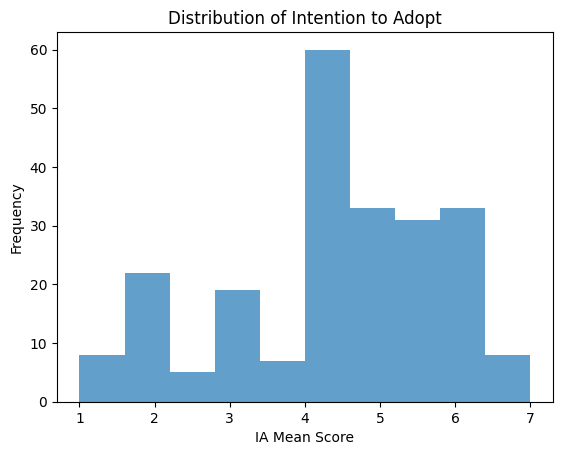

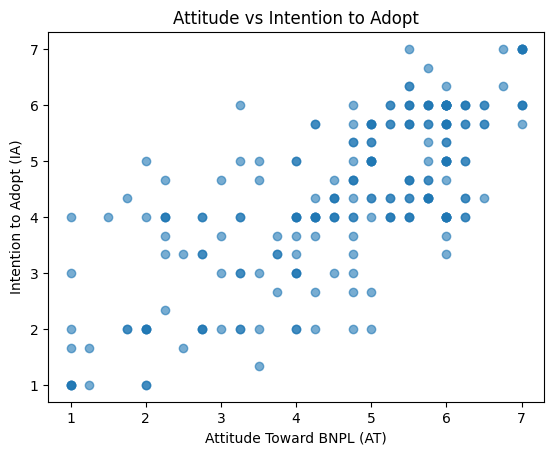

In [20]:
# Histogram of Intention to Adopt
if "Intention to Adopt (IA)" in construct_means:
    construct_means["Intention to Adopt (IA)"].plot.hist(bins=10, alpha=0.7)
    plt.title("Distribution of Intention to Adopt")
    plt.xlabel("IA Mean Score")
    plt.show()

# Scatter: Attitude vs Intention
if {"Attitude Toward BNPL (AT)", "Intention to Adopt (IA)"}.issubset(construct_means.columns):
    plt.scatter(
        construct_means["Attitude Toward BNPL (AT)"],
        construct_means["Intention to Adopt (IA)"],
        alpha=0.6
    )
    plt.title("Attitude vs Intention to Adopt")
    plt.xlabel("Attitude Toward BNPL (AT)")
    plt.ylabel("Intention to Adopt (IA)")
    plt.show()


In [23]:

df = pd.read_excel('/content/drive/MyDrive/BNPLIntentiontouse.xlsx')

# Define scales (others optional, but these are commonly present)
scales = {
    "FL": ["FL1", "FL2", "FL3"],
    "PE": ["PE1", "PE2", "PE3"],
    "EE": ["EE1", "EE2", "EE3", "EE4"],
    "SI": ["SI1", "SI2", "SI3"],
    "FC": ["FC1", "FC2", "FC3"],
    "PU": ["PU1", "PU2", "PU3"],
    "IA": ["IA1", "IA2", "IA3"],
    "AT": ["AT1", "AT2", "AT3", "AT4"],
}

# Enforce the ones we need
for label in ["FL", "PE", "PU", "IA"]:
    require_columns(df, scales[label], label)

# Reliability
print("=== Cronbach's alpha ===")
for label, cols in scales.items():
    present = [c for c in cols if c in df.columns]
    if len(present) >= 2:
        a = cronbach_alpha(df[present])
        print(f"{label}: {a:.3f} (n_items={len(present)})")
    else:
        print(f"{label}: N/A")

# Composite scores (means)
df["FL_Score"]  = df[scales["FL"]].mean(axis=1)
df["PU_Score"]  = df[scales["PU"]].mean(axis=1)
df["PRE_Score"] = df[scales["PE"]].mean(axis=1)  # PE used as PRE
df["IA_Score"]  = df[scales["IA"]].mean(axis=1)

# IA threshold (change if you want)
IA_THRESHOLD = 4.0
df["IA_binary"] = (df["IA_Score"] >= IA_THRESHOLD).astype(int)

# Drop rows with missing composites/target
model_cols = ["FL_Score", "PRE_Score", "PU_Score", "IA_binary"]
before = len(df)
df_model = df.dropna(subset=model_cols).copy()
print(f"Rows dropped due to missing composite values: {before - len(df_model)}")

# Quick peek
df_model[["FL_Score","PRE_Score","PU_Score","IA_Score","IA_binary"]].head()


=== Cronbach's alpha ===
FL: 0.850 (n_items=3)
PE: 0.856 (n_items=3)
EE: 0.846 (n_items=4)
SI: N/A
FC: N/A
PU: 0.699 (n_items=3)
IA: 0.931 (n_items=3)
AT: 0.945 (n_items=4)
Rows dropped due to missing composite values: 0


,FL_Score,PRE_Score,PU_Score,IA_Score,IA_binary
0,4.666667,5.000000,4.333333,4.000000,1
1,5.000000,4.666667,6.000000,2.000000,0
2,6.000000,4.666667,3.666667,3.333333,0
3,4.333333,3.000000,4.333333,2.000000,0
4,5.000000,5.333333,5.333333,3.333333,0


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, classification_report, confusion_matrix
)

RANDOM_STATE = 42
TEST_SIZE    = 0.30

X = df_model[["FL_Score", "PRE_Score", "PU_Score"]]
y = df_model["IA_binary"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

# Logistic Regression with scaling
lr_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])
lr_pipe.fit(X_train, y_train)

# Random Forest
rf = RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_train, y_train)

# Predictions & probabilities
y_pred_lr  = lr_pipe.predict(X_test)
y_prob_lr  = lr_pipe.predict_proba(X_test)[:, 1]
y_pred_rf  = rf.predict(X_test)
y_prob_rf  = rf.predict_proba(X_test)[:, 1]

def report(label, y_true, y_pred, y_prob):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1  = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_prob)
    print(f"\n=== {label} ===")
    print(f"Accuracy:  {acc:.3f}  Precision: {prec:.3f}  Recall: {rec:.3f}  F1: {f1:.3f}  ROC-AUC: {auc:.3f}")
    print("Classification report:\n", classification_report(y_true, y_pred, digits=3, zero_division=0))
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
    return auc

auc_lr = report("Logistic Regression", y_test, y_pred_lr, y_prob_lr)
auc_rf = report("Random Forest",       y_test, y_pred_rf, y_prob_rf)



=== Logistic Regression ===
Accuracy:  0.809  Precision: 0.794  Recall: 1.000  F1: 0.885  ROC-AUC: 0.931
Classification report:
               precision    recall  f1-score   support

           0      1.000     0.278     0.435        18
           1      0.794     1.000     0.885        50

    accuracy                          0.809        68
   macro avg      0.897     0.639     0.660        68
weighted avg      0.848     0.809     0.766        68

Confusion matrix:
 [[ 5 13]
 [ 0 50]]

=== Random Forest ===
Accuracy:  0.809  Precision: 0.836  Recall: 0.920  F1: 0.876  ROC-AUC: 0.825
Classification report:
               precision    recall  f1-score   support

           0      0.692     0.500     0.581        18
           1      0.836     0.920     0.876        50

    accuracy                          0.809        68
   macro avg      0.764     0.710     0.728        68
weighted avg      0.798     0.809     0.798        68

Confusion matrix:
 [[ 9  9]
 [ 4 46]]


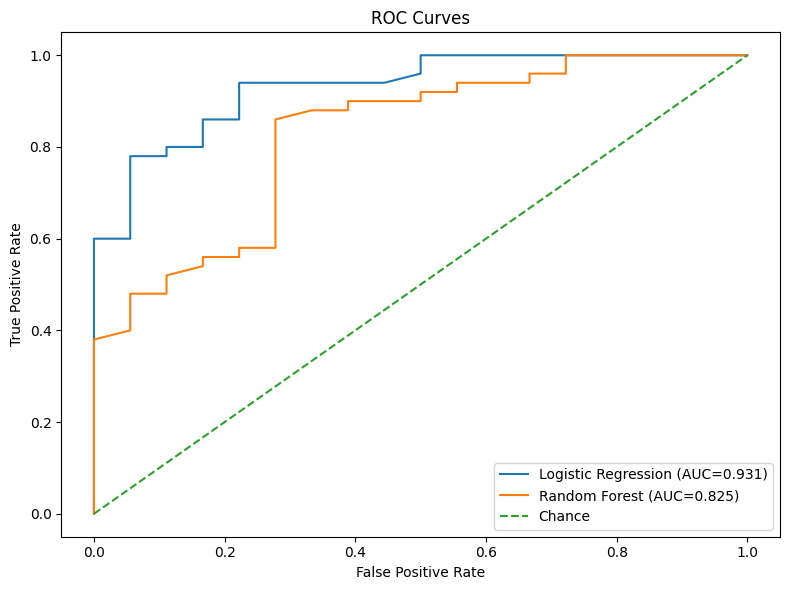

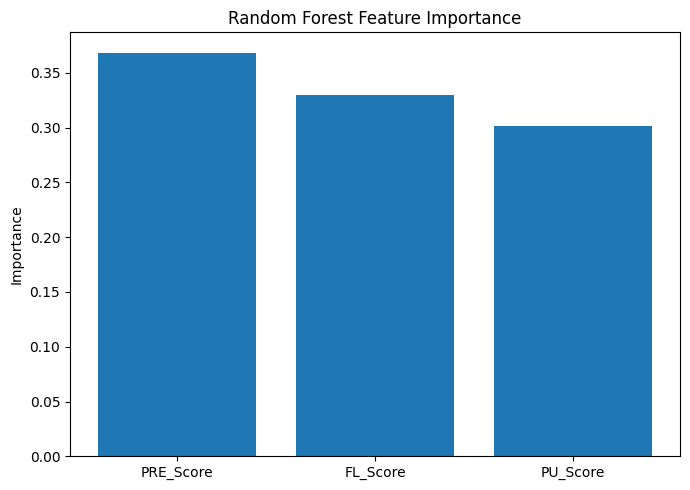

,0
FL_Score,1.294709
PRE_Score,2.339360
PU_Score,1.641750


In [27]:
import os

# Output directory
OUTDIR = "bnpl_outputs"
os.makedirs(OUTDIR, exist_ok=True)


# ROC curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC={auc_lr:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC={auc_rf:.3f})")
plt.plot([0,1],[0,1], linestyle="--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR,"roc_curves.png"), dpi=150)
plt.show()

# RF feature importance
importances = rf.feature_importances_
order = np.argsort(importances)[::-1]
features = X.columns.to_list()

plt.figure(figsize=(7,5))
plt.bar([features[i] for i in order], importances[order])
plt.ylabel("Importance")
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR,"rf_feature_importance.png"), dpi=150)
plt.show()

# Logistic Regression odds ratios (standardized units)
lr = lr_pipe.named_steps["lr"]
odds_ratios = pd.Series(np.exp(lr.coef_.ravel()), index=features)
odds_ratios.to_csv(os.path.join(OUTDIR,"logistic_odds_ratios.csv"), header=["odds_ratio"])
odds_ratios


In [28]:
!pip -q install shap lime

import shap
from lime import lime_tabular

# Enable JS-based SHAP viz (for force plots in notebooks)
shap.initjs()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [32]:
import numpy as np
import shap

def make_single_explanation_from_treeexplainer(
    explainer, shap_out, X, i=0, pos_class=1
) -> shap.Explanation:
    """
    Returns a single shap.Explanation for row i and positive class.
    Works whether shap_out is a list [class0, class1] or a 2D/3D array.
    """
    # shap_out could be:
    # - list of arrays [ (n_samples,n_features), (n_samples,n_features) ]
    # - Explanation object (with .values)
    # - numpy array (n_samples,n_features) or (n_samples,n_outputs,n_features)

    # Pull underlying array
    arr = None
    if isinstance(shap_out, list):
        # list per class: choose positive class
        arr = shap_out[pos_class]
        base_val = explainer.expected_value[pos_class]
        phi_i = arr[i]  # (n_features,)
    else:
        # shap_out may be a shap.Explanation or ndarray
        arr = getattr(shap_out, "values", shap_out)

        if arr.ndim == 2:
            # (n_samples, n_features)
            phi_i = arr[i]
            ev = explainer.expected_value
            base_val = ev[pos_class] if isinstance(ev, (list, np.ndarray)) else ev
        elif arr.ndim == 3:
            # (n_samples, n_outputs, n_features)
            phi_i = arr[i, pos_class, :]
            ev = explainer.expected_value
            base_val = ev[pos_class] if isinstance(ev, (list, np.ndarray)) else ev
        else:
            raise ValueError(f"Unexpected SHAP array shape: {arr.shape}")

    data_i = X.iloc[i, :].values
    names = X.columns.tolist()
    return shap.Explanation(values=phi_i, base_values=base_val, data=data_i, feature_names=names)


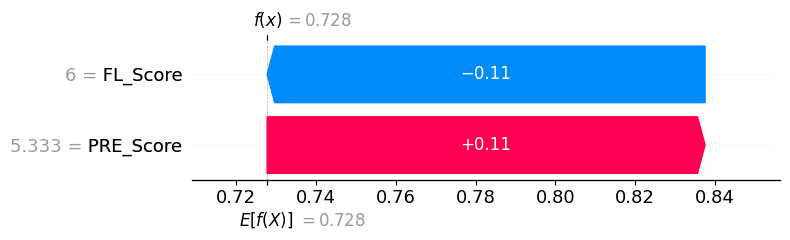

In [33]:
import os, matplotlib.pyplot as plt

# Pick which test row to explain
i = 0  # change within range(len(X_test))

# Build single-instance explanation for positive class
rf_exp_i = make_single_explanation_from_treeexplainer(
    explainer=rf_explainer,
    shap_out=rf_shap_test,   # what you computed earlier
    X=X_test,
    i=i,
    pos_class=1
)

plt.figure()
shap.plots.waterfall(rf_exp_i, show=False)
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, f"shap_rf_waterfall_i{i}.png"), dpi=150, bbox_inches="tight")
plt.show()
